In [1]:
import yfinance as yf
import plotly.graph_objs as go
import pandas as pd
import talib as ta
import numpy as np


def make_graph(ticker, name):
    df = yf.download(ticker, period='max') #index_col=0でindexを指定する必要がある
    close = df['Close']

    #5,25日移動平均の算出
    ma5, ma25, ma75 = ta.SMA(close, timeperiod=5), ta.SMA(close, timeperiod=25), ta.SMA(close, timeperiod=75)
    df['ma5'], df['ma25'], df['ma75'] = ma5, ma25, ma75

    ma5, ma25 = df['ma5'], df['ma25']
    cross = ma5 > ma25

    #ボリンジャーバンドの算出
    upper2, _, lower2 = ta.BBANDS(close, timeperiod=25,
                                  nbdevup=2, nbdevdn=2, matype=0)
    df['upper2'], df['lower2'] = upper2, lower2

    cross_shift = cross.shift(1)
    temp_gc = (cross != cross_shift) & (cross == True) #ゴールデンクロス
    temp_dc = (cross != cross_shift) & (cross == False) #デッドクロス

    #ゴールデンクロス発生日ならMA5の値、それ以外はNaN
    gc = [m if g == True else np.nan for g, m in zip(temp_gc, ma5)]
    #デッドクロス発生日ならMA25の値、それ以外はNaN
    dc = [m if d == True else np.nan for d, m in zip(temp_dc, ma25)]

    #データフレームのカラムとして保存
    df['gc'], df['dc'] = gc, dc

    #MACD,シグナル,ヒストグラムを算出
    macd, macdsignal, hist = ta.MACD(close, fastperiod=12,
                                     slowperiod=26, signalperiod=9)
    df['macd'] = macd
    df['macd_signal'] = macdsignal
    df['hist'] = hist

    #RSI
    rsi14 = ta.RSI(close, timeperiod=14)
    rsi28 = ta.RSI(close, timeperiod=28)
    df['rsi14'], df['rsi28'] = rsi14, rsi28
    
    #補助線
    df['70'], df['30'] = [70 for _ in close], [30 for _ in close]

    #ストキャスティクス
    slowK, slowD = ta.STOCH(df['High'], df['Low'], df['Close'],
                            fastk_period=5, slowk_period=3,
                            slowk_matype=0, slowd_period=3,
                            slowd_matype=0)
    df['slowK'], df['slowD'] = slowK, slowD

    #補助線
    df['80'], df['20'], = [80 for _ in close], [20 for _ in close]
    
    #データを8ヶ月分にする
    df = df.tail(200)
    
    #出来高の平均補助線
    df['volume_mean'] = [df['Volume'].mean() for _ in df['Close']]

    #インデックスを文字列型に
    df.index = pd.to_datetime(df.index).strftime('%m-%d-%Y')

    #レイアウト定義
    layout = {
        'height': 1000,
        'title' : {'text':'{}'.format(name) + ' {}'.format(ticker), 'x':0.5 },
        'xaxis' : {'rangeslider':{'visible':False}},
        'yaxis1' : {'domain':[.46, 1.0],'title':'価格', 'side':'left', 'tickformat':','},
        'yaxis2' : {'domain':[.40, .46]},
        'yaxis3' : {'domain':[.30, .395], 'title':'MACD', 'side':'right'}, #MACD
        'yaxis4' : {'domain':[.20, .295], 'title':'RSI', 'side':'right'}, #RSI
        'yaxis5' : {'domain':[.10, .195], 'title':'STC', 'side':'right'}, #ストキャスティクス
        'yaxis6' : {'domain':[.00, .095], 'title':'Volume', 'side':'right'}, #出来高
        'plot_bgcolor':'light blue'
    }

    #データ定義
    data = [
        #ローソク足
        go.Candlestick(yaxis='y1',
                       x=df.index, #x軸の値
                       open=df['Open'], #始値のシリーズ
                       high=df['High'], #高値のシリーズ
                       low=df['Low'], #安値のシリーズ
                       close=df['Close'], #終値のシリーズ
                       increasing_line_color = 'red', #陽線の緑の色
                       increasing_line_width = 1.0, #陽線のヒゲの幅
                       increasing_fillcolor = 'red', #陽線の実体の色
                       decreasing_line_color = 'gray', #陰線の緑の色
                       decreasing_line_width = 1.0, #陰線のヒゲの幅
                       decreasing_fillcolor = 'gray'), #陰線の実体の色
        #5日移動平均線
        go.Scatter(yaxis='y1',
                   x=df.index, 
                   y=df['ma5'], 
                   name='MA5',
                   line={'color':'royalblue', 'width':1.2}),
        #25日移動平均線
        go.Scatter(yaxis='y1',
                   x=df.index, 
                   y=df['ma25'], 
                   name='MA25',
                   line={'color':'lightseagreen', 'width':1.2}),
        #75日移動平均線
        go.Scatter(yaxis='y1',
                   x=df.index, 
                   y=df['ma75'], 
                   name='MA75',
                   line={'color':'green', 'width':1.2}),
        #ゴールデンクロス
        go.Scatter(yaxis='y1',
                   x=df.index,
                   y=df['gc'],
                   name='Golden Cross',
                   opacity = 0.5,
                   mode='markers',
                   marker={'size':15, 'color':'fuchsia'}),    
        #デッドクロス
        go.Scatter(yaxis='y1',
                   x=df.index,
                   y=df['dc'],
                   name='Dead Cross',
                   opacity = 0.5,
                   mode='markers',
                   marker={'size':15, 'color':'black', 'symbol':'x'}),
        #ボリンジャーバンド
        go.Scatter(yaxis='y1',
                   x=df.index,
                   y=df['upper2'],
                   name='',
                   line={'color':'lavender', 'width':0}),
        go.Scatter(yaxis='y1',
                   x=df.index,
                   y=df['lower2'],
                   name='BB',
                   line={'color':'lavender', 'width':0},
                   fill='tonexty',fillcolor='rgba(170, 170, 170, .2)'),
        #MACD
        go.Scatter(yaxis='y3',
                   x=df.index,
                   y=df['macd'],
                   name='macd',
                   line={'color':'slategray', 'width':1}),
        go.Scatter(yaxis='y3',
                   x=df.index,
                   y=df['macd_signal'],
                   name='macd_signal',
                   line={'color':'slategray', 'width':1}),
        go.Scatter(yaxis='y3',
                   x=df.index,
                   y=df['hist'],
                   name='histgram',
                   marker={'color':'slategray'}),
        #RSI
        go.Scatter(yaxis='y4',
                   x=df.index,
                   y=df['rsi14'],
                   name='RSI14',
                   line={'color':'magenta', 'width':1}),
        go.Scatter(yaxis='y4',
                   x=df.index,
                   y=df['rsi28'],
                   name='RSI28',
                   line={'color':'green', 'width':1}),
        #補助線
        go.Scatter(yaxis='y4',
                   x=df.index,
                   y=df['30'],
                   name='30',
                   line={'color':'black', 'width':1}),
        go.Scatter(yaxis='y4',
                   x=df.index,
                   y=df['70'],
                   name='70',
                   line={'color':'black', 'width':1}),
        #ストキャスティクス
        go.Scatter(yaxis='y5',
                   x=df.index,
                   y=df['slowK'],
                   name='slowK',
                   line={'color':'magenta', 'width':1}),
        go.Scatter(yaxis='y5',
                   x=df.index,
                   y=df['slowD'],
                   name='slowD',
                   line={'color':'green', 'width':1}),
        #補助線
        go.Scatter(yaxis='y5',
                   x=df.index,
                   y=df['20'],
                   name='20',
                   line={'color':'black', 'width':1}),
        go.Scatter(yaxis='y5',
                   x=df.index,
                   y=df['80'],
                   name='80',
                   line={'color':'black', 'width':1}),
        #出来高
        go.Bar(yaxis='y6',
               x=df.index,
               y=df['Volume'],
               name='Volume',
               marker={'color':'slategray'}),
        #補助線
        go.Scatter(yaxis='y6',
                   x=df.index,
                   y=df['volume_mean'],
                   name='mean',
                   line={'color':'black', 'width':1})
    ]

    fig = go.Figure(data=data, layout=go.Layout(layout))

    #レイアウトの更新
    fig.update_layout({
        'xaxis': {
            'tickmode': 'array',
            'tickvals': df.index[::2],
            'ticktext': ['{}-{}'.format(x.split('-')[0], x.split('-')[1]) for x in df.index[::2]]
        }
    })
    
    fig.show()

[*********************100%%**********************]  1 of 1 completed
/tmp/ipykernel_44/2568935159.py:65: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



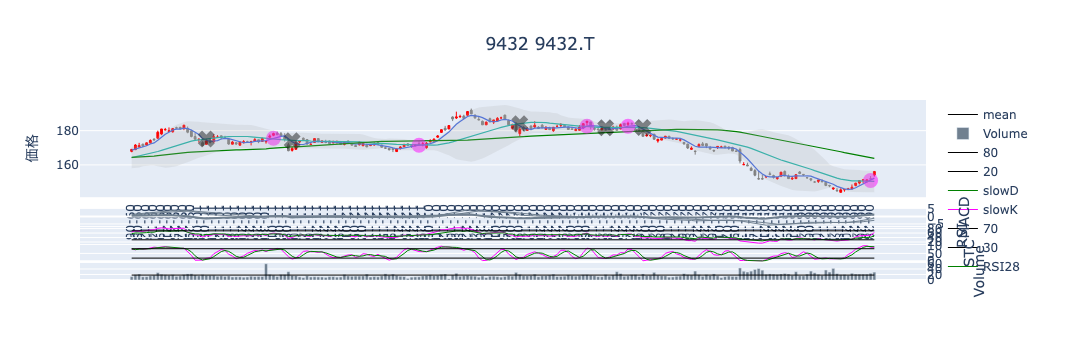

In [12]:
make_graph('9432.T','9432')